In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from coltra import HomogeneousGroup
from coltra.buffers import Observation
from coltra.models import MLPModel
from coltra.policy_optimization import CrowdPPOptimizer
from tqdm import trange

from cogment_lab.actors.nn_actor import ColtraActor
from cogment_lab.envs.gymnasium import GymEnvironment
from cogment_lab.process_manager import Cogment
from cogment_lab.utils.coltra_utils import convert_trial_data_to_coltra
from cogment_lab.utils.runners import process_cleanup
from cogment_lab.utils.trial_utils import concatenate


In [2]:
# Cleans up potentially hanging background processes from previous runs
process_cleanup()

Processes terminated successfully.


In [3]:
logpath = f"logs/logs-{datetime.datetime.now().isoformat()}"

cog = Cogment(log_dir=logpath)

print(logpath)

logs/logs-2024-02-18T12:49:28.276174


In [4]:
# We'll train on 

cenv = GymEnvironment(
    env_id="MountainCar-v0",
    render=True,
    make_kwargs={"max_episode_steps": 401},
)

await cog.run_env(env=cenv, 
                  env_name="mcar",
                  port=9011, 
                  log_file="env.log")


True

In [5]:
# Create a model using coltra

model = MLPModel(
    config={
        "hidden_sizes": [64, 64],
    }, 
    observation_space=cenv.env.observation_space, 
    action_space=cenv.env.action_space
)

# Put the model in shared memory so that the actor can access it
model.share_memory()
actor = ColtraActor(model=model)


await cog.run_actor(
    actor=actor,
    actor_name="coltra",
    port=9021,
    log_file="actor.log"
)

True

In [6]:
# Check what's running

cog.processes

{'mcar': <SpawnProcess name='cogment_lab_mcar' pid=19583 parent=19557 started>,
 'coltra': <SpawnProcess name='cogment_lab_coltra' pid=19585 parent=19557 started>}

In [7]:
MOUNTAIN_CAR_ACTIONS = ["no-op", "ArrowLeft", "ArrowRight"]

actions = MOUNTAIN_CAR_ACTIONS

await cog.run_web_ui(actions=actions, log_file="human.log", fps=30)

True

In [8]:
# Estimate random agent performance

episodes = []
for i in trange(10):
    trial_id = await cog.start_trial(
        env_name="mcar",
        session_config={"render": False},
        actor_impls={
            "gym": "coltra",
        },
    )
    multi_data = await cog.get_trial_data(trial_id=trial_id)
    data = multi_data["gym"]
    episodes.append(data)
mean_reward = np.mean([sum(e.rewards) for e in episodes])
print(f"mean_reward: {mean_reward}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.89it/s]

mean_reward: -401.0


In [9]:
# Train for a bit with PPO

ppo = CrowdPPOptimizer(HomogeneousGroup(actor.agent), config={
    "gae_lambda": 0.95,
    "minibatch_size": 128,
})

all_rewards = []

for t in (pbar := trange(10)):
    num_steps = 0
    episodes = []
    while num_steps < 1000:
        trial_id = await cog.start_trial(
            env_name="mcar",
            session_config={"render": False},
            actor_impls={
                "gym": "coltra",
            },
        )
        multi_data = await cog.get_trial_data(trial_id=trial_id, env_name="mcar")
        data = multi_data["gym"]
        episodes.append(data)
        num_steps += len(data.rewards)
        
    all_data = concatenate(episodes)
    
    record = convert_trial_data_to_coltra(all_data, actor.agent)
    metrics = ppo.train_on_data({"crowd": record}, shape=(1,) + record.reward.shape)
    
    mean_reward = metrics["crowd/mean_episode_reward"]
    all_rewards.append(mean_reward)
    pbar.set_description(f"mean_reward: {mean_reward:.3}")
        


mean_reward: -4.01e+02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]


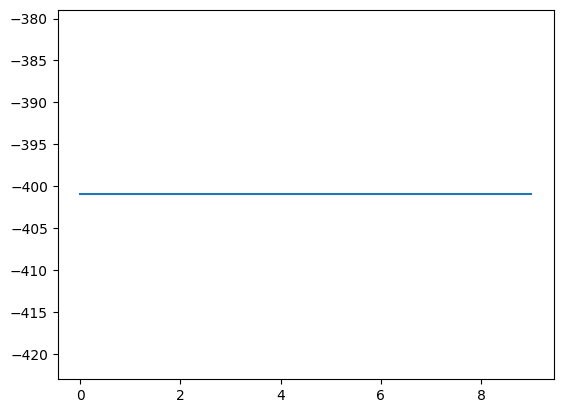

In [10]:
plt.plot(all_rewards)


In [11]:
# Reinitialize the agent

cog.stop_service("coltra")

model = MLPModel(
    config={
    "hidden_sizes": [64, 64],
    }, 
    observation_space=cenv.env.observation_space, 
    action_space=cenv.env.action_space
)

# Put the model in shared memory so that the actor can access it
model.share_memory()
actor = ColtraActor(model=model)


await cog.run_actor(
    actor=actor,
    actor_name="coltra",
    port=9021,
    log_file="actor.log"
)

True

In [12]:
# Get some human episodes
episodes = []
for i in range(1):
    trial_id = await cog.start_trial(
        env_name="mcar",
        session_config={"render": True},
        actor_impls={
            "gym": "web_ui",
        },
    )
    multi_data = await cog.get_trial_data(trial_id=trial_id, env_name="mcar")
    data = multi_data["gym"]
    episodes.append(data)
    
all_data = concatenate(episodes)

In [13]:
mean_reward = np.mean([sum(e.rewards) for e in episodes])
print(f"mean_reward: {mean_reward}")
print(f"rewards: {[sum(e.rewards) for e in episodes]}")

mean_reward: -149.0
rewards: [-149.0]


In [14]:
cog.stop_service("web_ui")

In [15]:
all_obs = Observation(vector=all_data.observations).tensor()
all_actions = torch.tensor(all_data.actions)

In [16]:
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for t in (pbar := trange(500)):
    preds = model(all_obs)[0].logits
    loss = F.cross_entropy(preds, all_actions)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    pbar.set_description(f"loss: {loss.item():.3}")
    
    losses.append(loss.item())
    

loss: 0.176: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1045.44it/s]


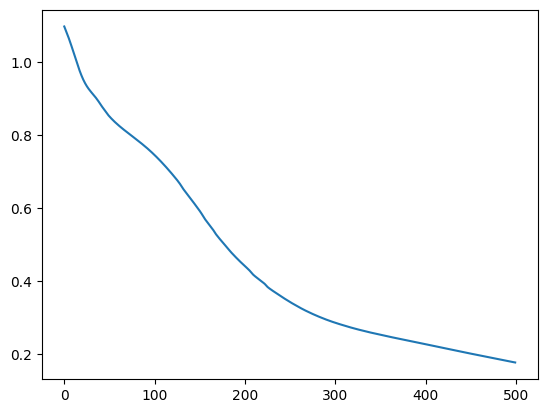

In [17]:
plt.plot(losses)

In [18]:
# Estimate agent performance

episodes = []
for i in trange(10):
    trial_id = await cog.start_trial(
        env_name="mcar",
        session_config={"render": False},
        actor_impls={
            "gym": "coltra",
        },
    )
    multi_data = await cog.get_trial_data(trial_id=trial_id, env_name="mcar")
    data = multi_data["gym"]
    episodes.append(data)
mean_reward = np.mean([sum(e.rewards) for e in episodes])
print(f"mean_reward: {mean_reward}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]

mean_reward: -163.6


In [19]:
await cog.cleanup()